Import the relevant libraries and enviornment in OpenAI gym. 

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline       
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment = gym.make('CartPole-v0').unwrapped

### Replay Memory

Create a class which will permit us to incorporate experience replay when training the DQN. 
This essentially stores the transitions observed by the agent. The transitions that build up a batch are decorrelated by the sampling process. 


In [2]:
# This maps state-action pairs to their next state and reward. 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ExperienceReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN Algorithm


The model is a CNN whereby the difference between the current and previous screen patches are fed into it. 

The model has two outputs; Q(s,left) and Q(s,right). The network is trying to predict the expected reward/return of taking an action given the current input.

In [3]:
class DQNAlgorithm(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQNAlgorithm, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv_layer2 = nn.Conv2d(8, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv_layer3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # The number of linear input connections depends on the number of conv2d layers
        def conv2d_layer_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_layer_size_out(conv2d_layer_size_out(conv2d_layer_size_out(w)))
        convh = conv2d_layer_size_out(conv2d_layer_size_out(conv2d_layer_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Determines next action during optimisation
    def forward(self, x):
        x = F.relu(self.bn1(self.conv_layer1(x)))
        x = F.relu(self.bn2(self.conv_layer2(x)))
        x = F.relu(self.bn3(self.conv_layer3(x)))
        return self.head(x.view(x.size(0), -1))

### Extract Rendered Images From Enviornment

This will display an example patch that it extracted.

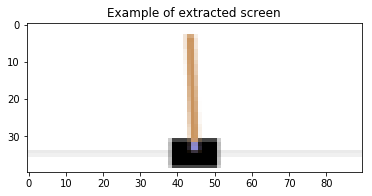

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_location_of_cart(screen_width):
    world_width = environment.x_threshold * 2
    scale = screen_width / world_width
    return int(environment.state[0] * scale + screen_width / 2.0)  

def get_screen():
    screen = environment.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    location_of_cart = get_location_of_cart(screen_width)
    if location_of_cart < view_width // 2:
        slice_range = slice(view_width)
    elif location_of_cart > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(location_of_cart - view_width // 2,
                            location_of_cart + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

environment.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example of extracted screen')
plt.show()

### Model Training

- choose_action - will choose an action accordingly to an epsilon greedy policy. 
- plot_durations - plots the durations of episodes.

In [9]:
BATCH_SIZE = 128
GAMMA_VALUE = 0.95
EPISODE_START = 0.9
EPISODE_END = 0.05
EPISODE_DECAY = 200
TARGET_UPDATE = 20

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = environment.action_space.n

policy_net = DQNAlgorithm(screen_height, screen_width, n_actions).to(device)
target_net = DQNAlgorithm(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ExperienceReplayMemory(10000)

steps_done = 0

def choose_action(state):
    global steps_done
    sample = random.random()
    episode_threshold = EPISODE_END + (EPISODE_START - EPISODE_END) * \
        math.exp(-1. * steps_done / EPISODE_DECAY)
    steps_done += 1
    if sample > episode_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 50:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    plt.show()

### Training


Finally, the code for training our model. This function performs a single step of the optimization. Firstly it samples a batch and concatenates all the tensors into a single one. 
The computes Q(st,at) and V(st+1)=maxaQ(st+1,a) and combines them into a loss. By definition we set V(s)=0 if s is a terminal state. We also use a target network to compute V(st+1) for added stability. 

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    not_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    not_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) then select the columns of actions taken. 
    # These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[not_final_mask] = target_net(not_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA_VALUE) + reward_batch

    # Compute Huber loss function
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

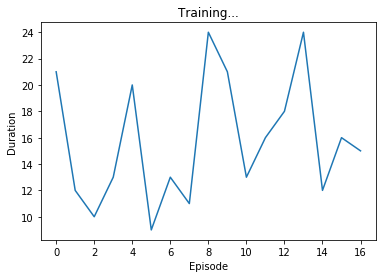

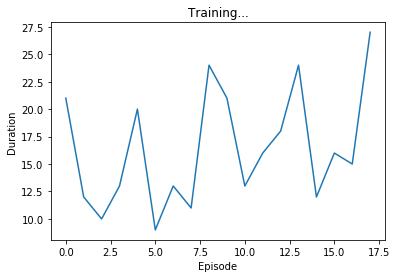

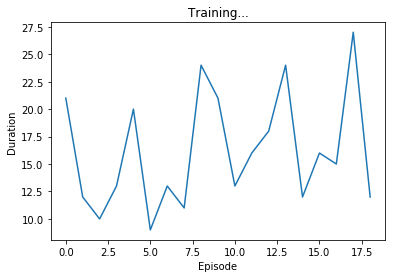

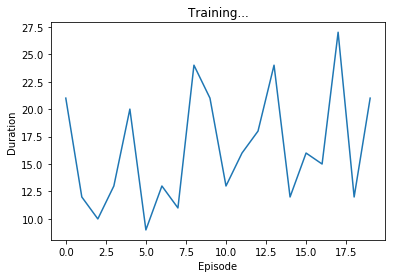

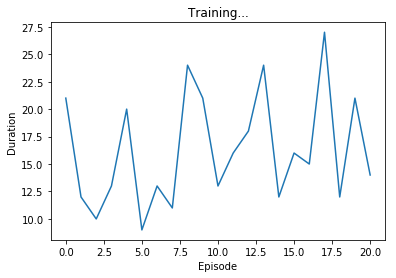

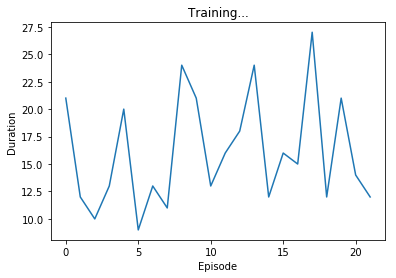

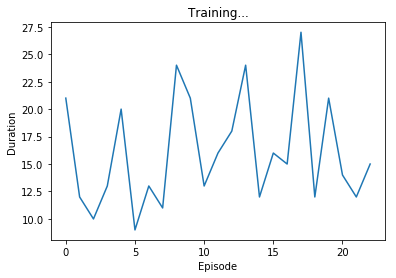

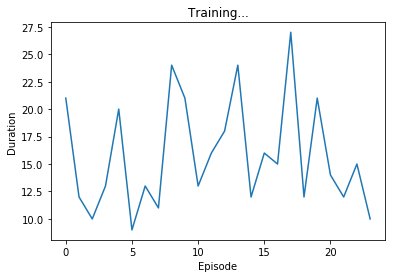

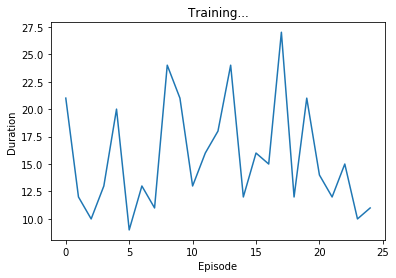

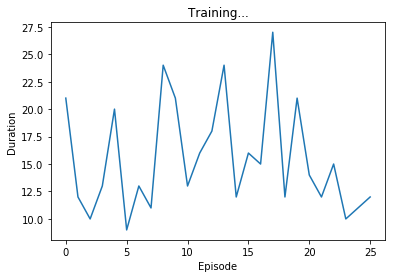

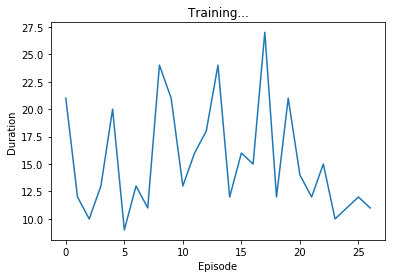

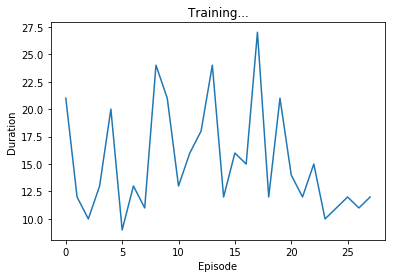

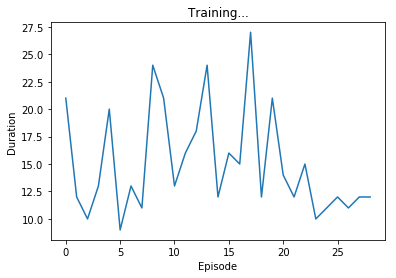

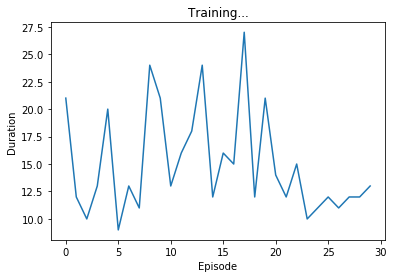

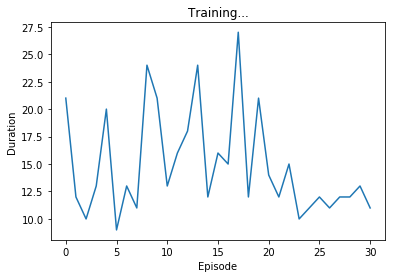

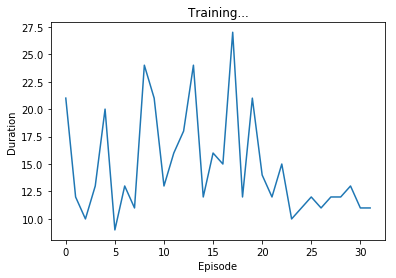

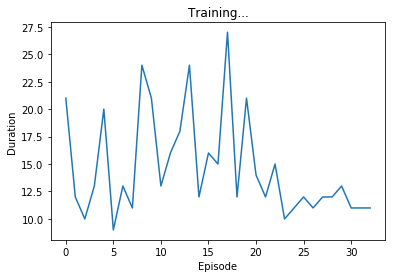

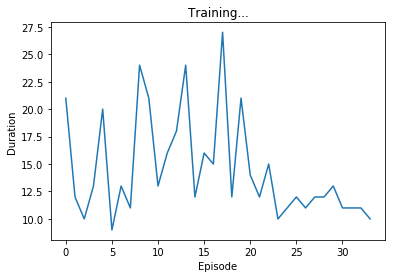

In [ ]:
num_episodes = 50
for i in range(num_episodes):
    environment.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = choose_action(state)
        _, reward, done, _ = environment.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network; copy all weights and biases in the DQN
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
environment.render()
environment.close()
plt.ioff()
plt.show()